## LDA for dimensionality reduction
Note: Compare to other techniques like PCA 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# For discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

In [3]:
CSVMetaData = '../datasets/ACDC_radiomics.csv'
data=pd.read_csv(CSVMetaData)

In [4]:
# Separate features and target
y = data["class"]  # Make sure this is the correct class label column
X = data.select_dtypes(include=[np.number])  # Only numeric features

# Standardize the data (mean = 0, std = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original data dimensions: {X.shape}")

Original data dimensions: (100, 644)


In [5]:
# Train-test split (recommended before LDA to evaluate performance later)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Initialize LDA: the number of components is limited to (n_classes - 1)
n_classes = len(np.unique(y))
lda = LDA(n_components=min(n_classes - 1, X.shape[1]))  # LDA max components = num_classes - 1

# Fit LDA on training data
X_lda_train = lda.fit_transform(X_train, y_train)
X_lda_test = lda.transform(X_test)

print(f"Explained variance ratio (discriminability) by LDA components: {lda.explained_variance_ratio_}")
print(f"Total variance explained by LDA: {lda.explained_variance_ratio_.sum():.2f}")

Explained variance ratio (discriminability) by LDA components: [0.59887811 0.23561906 0.11229118 0.05321165]
Total variance explained by LDA: 1.00


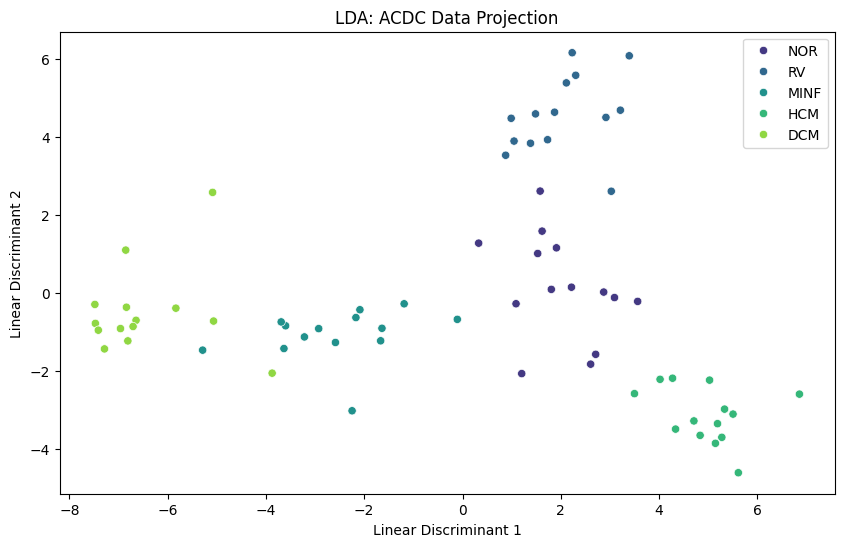

In [6]:
# Combine transformed data with labels for visualization
df_lda = pd.DataFrame(X_lda_train, columns=[f"LD{i+1}" for i in range(X_lda_train.shape[1])])
df_lda["class"] = y_train.values

# Plot first two Linear Discriminants (if at least 2 exist)
if X_lda_train.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="LD1", y="LD2", hue="class", data=df_lda, palette="viridis")
    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.title("LDA: ACDC Data Projection")
    plt.legend()
    plt.show()
else:
    print("Less than 2 LDA components, skipping 2D plot.")